In [1]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/toc3/press


In [2]:
from functools import partial
from xgboost import XGBClassifier
from gplearn.genetic import SymbolicClassifier

In [3]:
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.components import press
from express.visualization import plot_action
from express.utils import add_names

In [4]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f0b3d57c730>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f0b3d57cfa0>


In [5]:
dataset_train = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "train"))
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))

print("dataset_train:", dataset_train)
print("dataset_test:", dataset_test)

dataset_train: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/press/stores/datasets/train')
dataset_test: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/press/stores/datasets/test')


In [6]:
# xgboost, symbolic_regression
test_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "test"),
    xfns=["startlocation", "closest_11_players"],
    yfns=["counterpress"],
    load_cached=True,
    nb_prev_actions=3
)

# soccermap
# test_dataset = PressingDataset(
#     path= os.path.join(base_path, "stores", "datasets", "test"),
#     xfns=["startlocation", "freeze_frame_360"],
#     yfns=["counterpress"],
#     load_cached=True,
#     nb_prev_actions=1
# )

print(f"Test DataSet: {test_dataset.features.shape}")
print(f"Test Dataset: {test_dataset.labels.value_counts().to_dict()}")

Test DataSet: (12406, 195)
Test Dataset: {(False,): 9954, (True,): 2452}


In [7]:
model = "xgboost" #"soccermap"
trial = 0
save_path = os.path.join(base_path, "stores", "model", model, f"{trial:03d}", "component.pkl")
save_path

'/home/toc3/press/stores/model/xgboost/000/component.pkl'

In [8]:
from express.components.base import exPressComponent
import pickle
from pathlib import Path

path = Path(save_path)
component = pickle.load(path.open(mode="rb"))
component

In [9]:
component.test(dataset_train)

{'precision': 0.7411380597014925,
 'recall': 0.4270931326434619,
 'f1': 0.5419046807059426,
 'log_loss': 0.3313699207196391,
 'brier': 0.10037683322455809,
 'roc_auc': 0.8801689868010035}

In [10]:
component.test(dataset_test)

{'precision': 0.6985138004246284,
 'recall': 0.4025285481239804,
 'f1': 0.5107373868046573,
 'log_loss': 0.3558048260878031,
 'brier': 0.10917502261845621,
 'roc_auc': 0.8554234470407267}

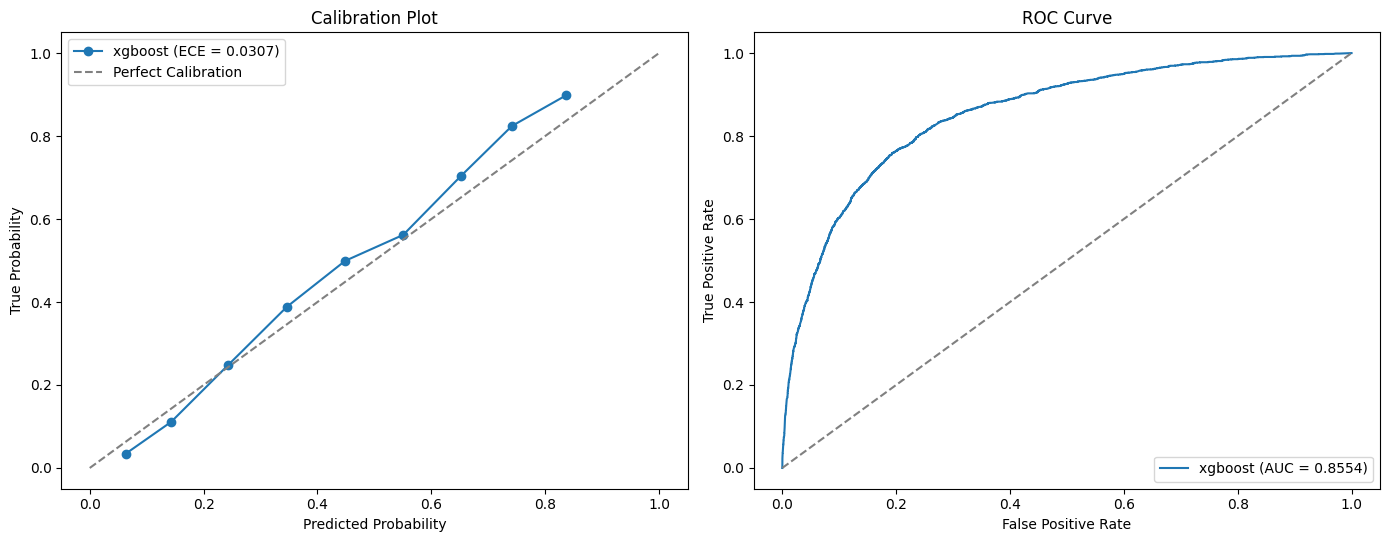

In [12]:
import torch
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, roc_auc_score
from torchmetrics.classification import BinaryCalibrationError

def plot_calibration_curves(y_true, y_pred, ax):
    bce_l1 = BinaryCalibrationError(n_bins=10, norm='l1')
    ece = bce_l1(torch.Tensor(y_pred), torch.Tensor(y_true))

    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label=f'{model} (ECE = {ece:.4f})')

    ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Perfect Calibration')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('True Probability')
    ax.set_title('Calibration Plot')
    ax.legend()

def plot_roc_curves(y_true, y_pred, ax):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    ax.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')

    ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')


y_pred = component.predict(dataset_test).values
y_true = test_dataset.labels["counterpress"].values

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_calibration_curves(y_true, y_pred, axes[0])
plot_roc_curves(y_true, y_pred, axes[1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### XGBoost feature importances

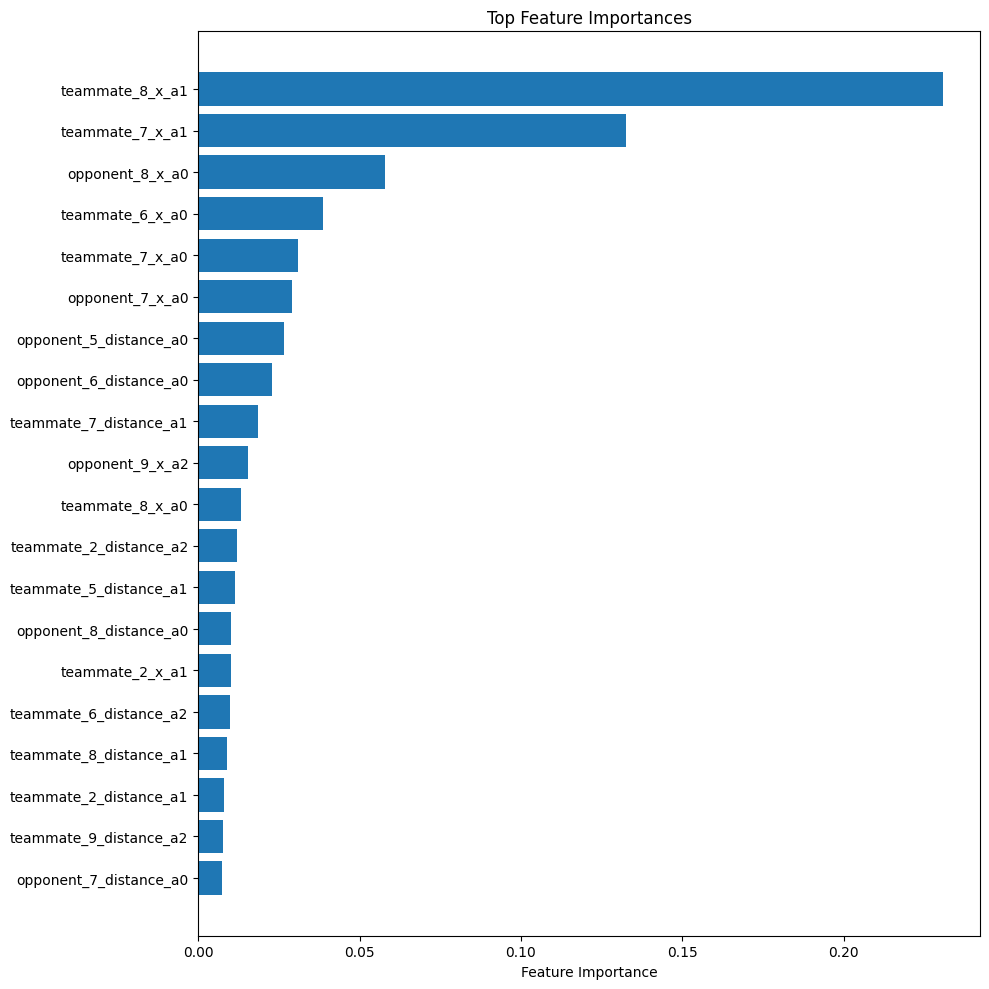

In [17]:
k = 20  # 원하는 k 값을 설정하세요 (상위 k개)

features = [col for _, cols in component.features.items() for col in cols]
importances = component.model.feature_importances_
indices = np.argsort(importances)[-k:]

plt.figure(figsize=(max(10, k * 0.5), 10))  
plt.barh(range(k), importances[indices], align='center')
plt.yticks(range(k), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()


In [18]:
game_id = 3788741

df_actions = add_names(train_db.actions(game_id)).reset_index()
df_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3788741,0,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,1,0.878,909,11086,52.0625,34.425,28.0000,...,From Kick Off,0,1.910504,"{'pass': {'recipient': {'id': 8963, 'name': 'C...","[[0.0, 44.39976078697438], [16.82907029647681,...",0,"[{'teammate': False, 'actor': False, 'keeper':...",pass,success,foot_right
1,3788741,1,bea4235d-7e40-461c-bb82-6d473f5bb324,1,2.789,909,8963,28.0000,43.945,31.2375,...,From Kick Off,0,1.499077,"{'carry': {'end_location': [36.2, 30.4]}}","[[30.27094296623723, 2.3520882891309185], [5.7...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",dribble,success,foot
2,3788741,2,84b9b798-0fbe-45bc-a4bf-3621959f29ce,1,4.288,909,8963,31.2375,42.585,61.4250,...,From Kick Off,0,2.476772,"{'pass': {'recipient': {'id': 8541, 'name': 'K...","[[31.00063614049526, 1.2150785249513518], [6.7...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_left
3,3788741,3,6e2955cf-ad4f-4096-a4dd-053173a3802b,1,6.751,914,8286,63.2625,6.715,63.2625,...,From Kick Off,0,0.080000,{},"[[87.6897292922602, 68.0], [68.82521396005053,...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,fail,foot
4,3788741,4,1615d483-101d-45c1-b554-04cf69897232,1,6.764,909,8541,61.4250,3.995,61.1625,...,From Kick Off,1,0.101747,"{'carry': {'end_location': [70.4, 75.5]}}","[[69.32405800689574, 0.0], [40.54450680816471,...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",dribble,success,foot


### Visualization

Skip action due to missing freeze frame


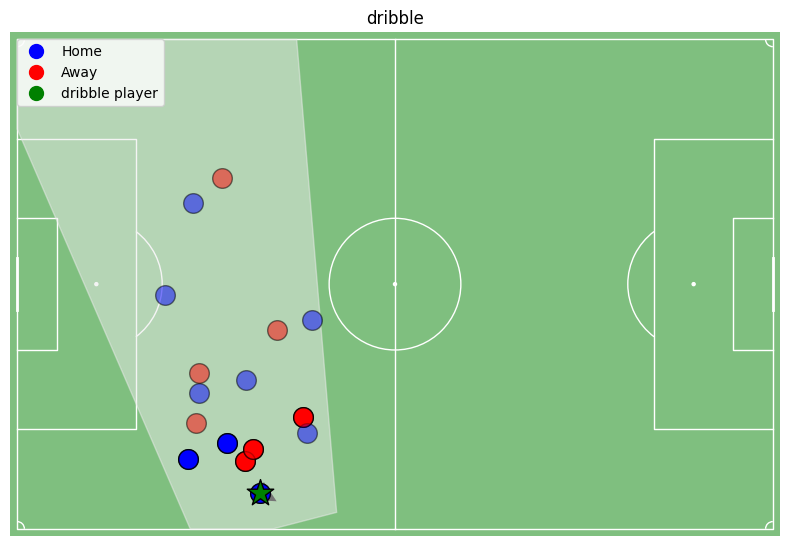

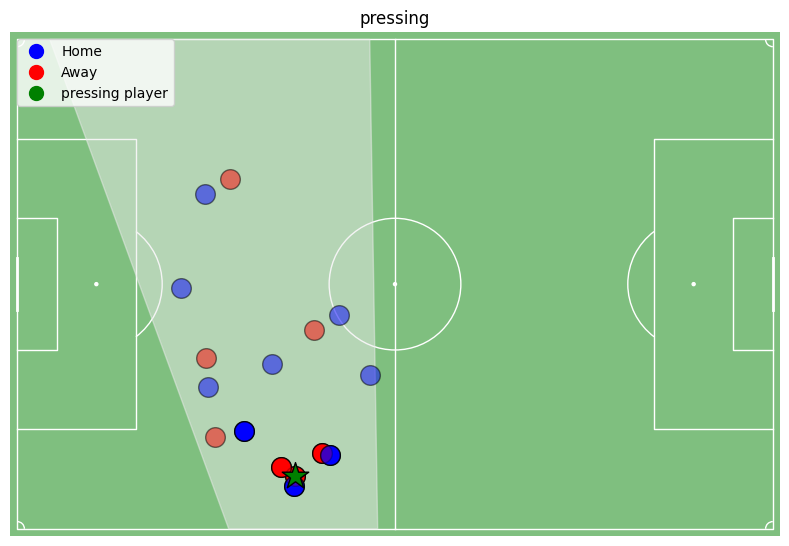

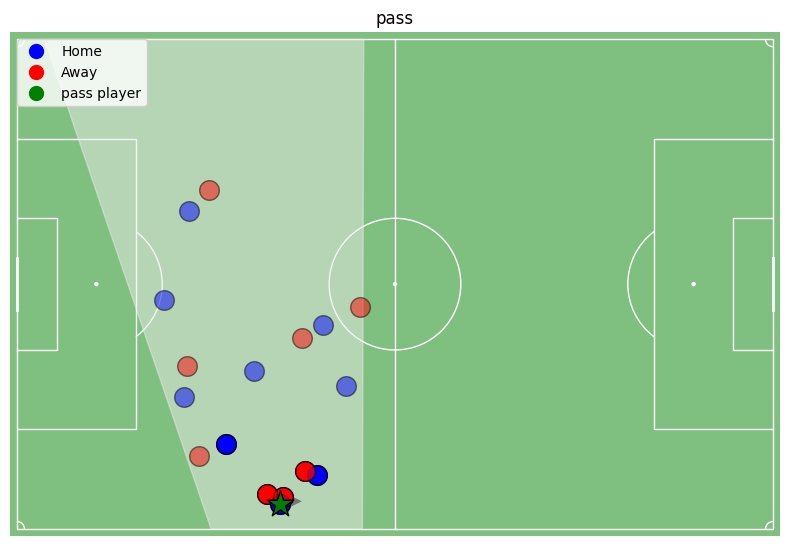

In [19]:
pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[5]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3788741)
for idx in range(pressure_idx-2, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame")
        continue
    plot_action(df_actions.loc[idx], home_team_id=home_team_id)